# Classification of trapped particles
Using scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *

# Load the time domain data 

In [2]:
#path to the folder where data is stored
folder_path = "dataset//17-06-2021//"

#list the paths ending in .TDdat
path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.TDdat')]

#store the info for each file
target = [] 
x_data = []
y_data = []
t_data = []
sum_data = []

#number of splits
splits = 20

#read data
for i in range(0,len(path_files_TD)):
    
    current_path = path_files_TD[i]
    print(current_path)
    #read type
    for i in range(0,splits):
        target.append(current_path.split('//')[2].split('.')[0])
    
    #load data
    current_df = pd.read_csv(current_path,skiprows=5,header=None,delimiter=' ')
    t_data.append(np.array_split(np.array(current_df[0]),splits))
    x_data.append(np.array_split(np.array(current_df[1]),splits))
    y_data.append(np.array_split(np.array(current_df[2]),splits))
    sum_data.append(np.array_split(np.array(current_df[3]),splits))

dataset//17-06-2021//3umPMMA.TDdat
dataset//17-06-2021//3umPOLY.TDdat
dataset//17-06-2021//4UMpoly.TDdat
dataset//17-06-2021//8umPMMA.TDdat
dataset//17-06-2021//8umPOLY.TDdat
dataset//17-06-2021//water.TDdat


## Plot acquired data

<IPython.core.display.Javascript object>


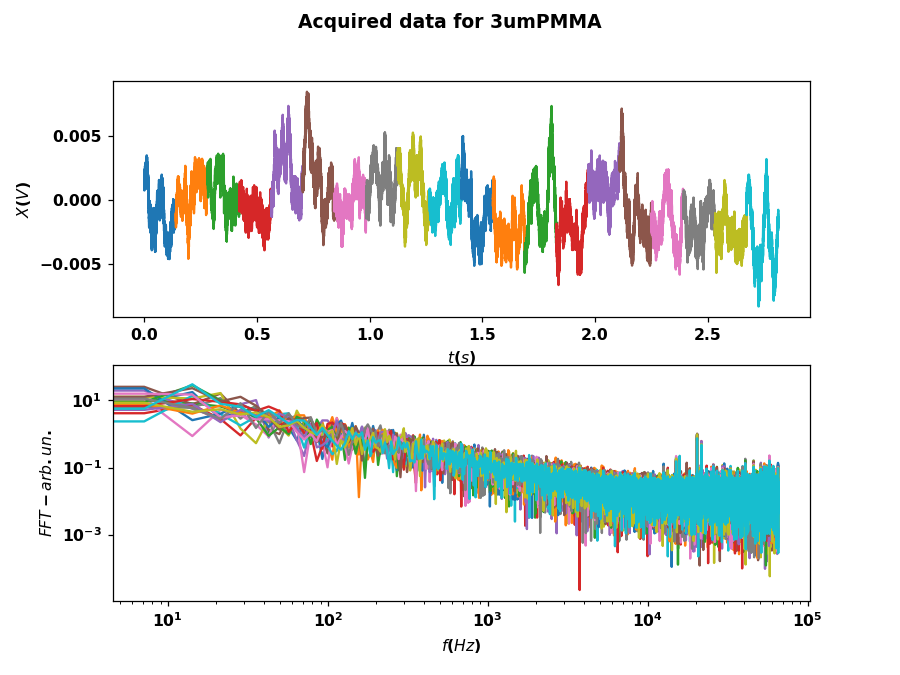

In [3]:
%matplotlib notebook

index1 = 3
figure(figsize=[8,6])
subplot(211)
ax1=gca()
ax1.set_xlabel(r"$t (s)$")
ax1.set_ylabel(r"$X (V)$")
subplot(212)
ax2=gca()
ax2.set_xlabel(r"$f (Hz)$")
ax2.set_ylabel(r"$FFT - arb.un.$")
ax2.set_yscale('log')
ax2.set_xscale('log')

for chunk in range(0, splits):
    suptitle("Acquired data for " + target[index1])
    
    ax1.plot(t_data[index1][chunk],x_data[index1][chunk],label="Split "+str(chunk))
    
    
    data_to_fft = x_data[index1][chunk]
    fft_data = np.fft.fft(data_to_fft)
    dt = t_data[index1][chunk][1]-t_data[index1][chunk][0]
    freqs = np.fft.fftfreq(len(data_to_fft),dt)
    fft_data = np.fft.fftshift(fft_data)
    freqs = np.fft.fftshift(freqs)
    
    plot(freqs,abs(fft_data) ,label="Split "+str(chunk))

    
    


# Classify data
Prepare the data, based on the FFT of each chunk

In [4]:
data_to_classify = []
for i in range(0,len(x_data)):
    for j in range(0,len(x_data[i])):
        data_to_classify.append(np.abs(np.fft.fft(x_data[i][j])))

data_to_classify=np.array(data_to_classify)

dummy_labels = []
labels = []
unique_targets = np.unique(target)
for i in range(0,len(target)):
    arr = np.zeros(len(unique_targets))
    labels.append(np.where(target[i]==unique_targets)[0][0])
    index = np.where(target[i]==unique_targets)[0][0]
    arr[index] = 1 
    dummy_labels.append(arr)

labels=np.array(labels)
dummy_labels = np.array(dummy_labels)

## PCA Analysis
Decompose the data based on principal components

<IPython.core.display.Javascript object>


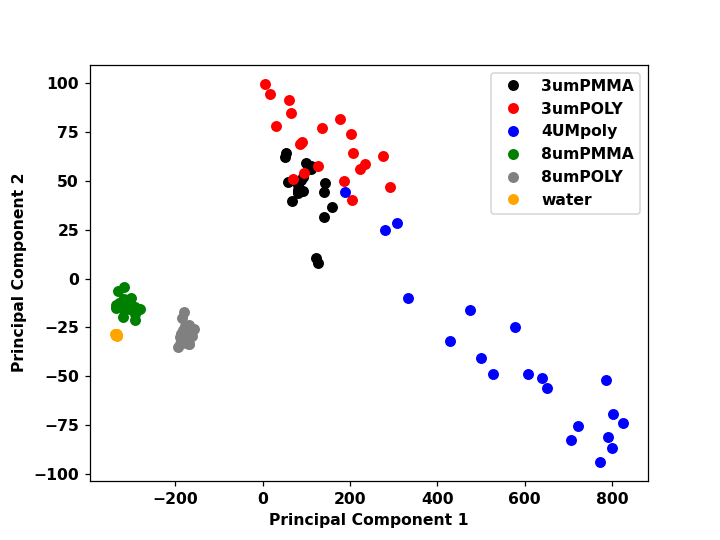

In [5]:
from sklearn import *

ncomp=30

model = decomposition.PCA(n_components=ncomp)
model.fit(data_to_classify)
PCs = model.transform(data_to_classify)

subplots()
label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(labels==0)[0]
i1= np.where(labels==1)[0]
i2= np.where(labels==2)[0]
i3= np.where(labels==3)[0]
i4= np.where(labels==4)[0]
i5= np.where(labels==5)[0]

pc1 = 0
pc2 = 1
c=['k','r','b','g','gray','orange']


plot(PCs[i0,pc1],PCs[i0,pc2],'o',color=c[0],label=label0)
plot(PCs[i1,pc1],PCs[i1,pc2],'o',color=c[1],label=label1)
plot(PCs[i2,pc1],PCs[i2,pc2],'o',color=c[2],label=label2)
plot(PCs[i3,pc1],PCs[i3,pc2],'o',color=c[3],label=label3)
plot(PCs[i4,pc1],PCs[i4,pc2],'o',color=c[4],label=label4)
plot(PCs[i5,pc1],PCs[i5,pc2],'o',color=c[5],label=label5)
xlabel("Principal Component 1")
ylabel('Principal Component 2')
legend()

# Classifier based on PCA

In [6]:
from sklearn import *

ts=0.2
rs=30

X_train, X_test, y_train, y_test = model_selection.train_test_split(PCs, labels, test_size=ts, random_state=rs)

#model = cross_decomposition.PLSRegression().fit(X=data_to_classify,Y=dummy_labels)
#model = discriminant_analysis.LinearDiscriminantAnalysis()
#model = linear_model.LogisticRegression()
#model = svm.SVC()
model = ensemble.RandomForestClassifier(n_estimators=60)
model.fit(X_train,y_train)

print('Score test')
print(model.score(X_test,y_test))

Score test
0.9166666666666666


# Scoring the model

Model Accuracy -> 0.8208333333333334


<IPython.core.display.Javascript object>


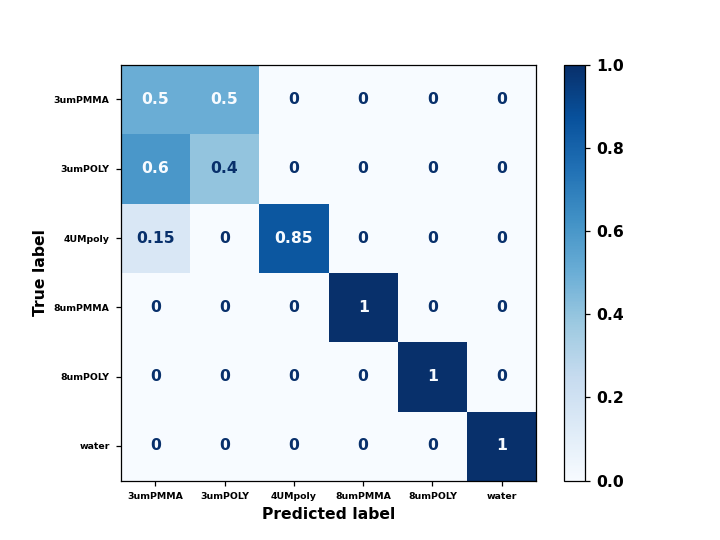

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '3umPMMA'),
  Text(1, 0, '3umPOLY'),
  Text(2, 0, '4UMpoly'),
  Text(3, 0, '8umPMMA'),
  Text(4, 0, '8umPOLY'),
  Text(5, 0, 'water')])

In [7]:
#Crossvalidation score
ts=0.2
rs=0
nfolds=30

cv = model_selection.ShuffleSplit(n_splits=nfolds, test_size=ts, random_state=rs)
scores = model_selection.cross_val_score(model, PCs, labels, cv=cv)
print("Model Accuracy -> " + str(np.mean(scores)))

#Generate a confusion matrix
labels_pred = model_selection.cross_val_predict(model, PCs, labels, cv=5)
conf_mat = metrics.confusion_matrix(labels, labels_pred,normalize="true")
metrics.ConfusionMatrixDisplay(conf_mat,display_labels=unique_targets).plot(cmap=cm.Blues)
yticks(fontsize=6)
xticks(fontsize=6)